In [247]:
import re

import requests

# import html parsers before BeautifulSoup
import lxml

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import networkx as nx

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import powerlaw

In [208]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [218]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

# Data quality analysis

The goal of this project is to explore the Wikipedia clickstream datasets using network analyis. The first step towards that goal is to perform data quality analysis, which involves looking at the raw data, understanding its structure, and finding any anomalies in the raw data. 

### 1. Data sources

[This is the Wikipedia clickstream datasets dump](https://dumps.wikimedia.org/other/clickstream/). It contains monthly Wikipedia clickstream data dumps for a selection top Wikipedia languages. The earliest datasets available are for November 2011, for the following 5 languages: German, English, Spanish, Japanese and Russian. In 2018, the list of languages has expanded to 11.

#### Let's make a list of all available Wikipedia clickstream datasets, as of January 2019.


The datasets are labelled by ISO language codes. We can convert those codes to English with the function below.

In [138]:
# Helper function to convert ISO language codes to common language names
iso_language_codes_github_url = \
    "https://raw.githubusercontent.com/datasets/language-codes/master/data/language-codes.csv"
iso_language_codes = pd.read_csv(iso_language_codes_github_url)

def get_language_name(iso_language_code):
    return iso_language_codes.loc[iso_language_codes["alpha2"] == iso_language_code.lower()]["English"] \
                .values[0].split(";")[0]

A quick web scrape of the currently available dataset sizes, by month and language.

In [136]:
# Request the datasets dump page to get a list of month folders
clickstream_url = "https://dumps.wikimedia.org/other/clickstream/"
clickstream_url_response = requests.get(clickstream_url)

# Soup it
clickstream_url_soup = BeautifulSoup(clickstream_url_response.text)

In [145]:
# Scrape the months pages, and collect the datafiles info into a dict
# Note: this loops requests to the Wikimedia datadump pages, so don't rerun too frequently
datasets_dict = {}
for l in clickstream_url_soup.find_all("a"):
    month_folder_href_check = re.match(r"\d{4}-\d{2}/", l['href'])
    if month_folder_href_check:
        month_url = clickstream_url + l['href']
        month_response = requests.get(month_url)
        month_soup = BeautifulSoup(month_response.text)    
        files_list_raw = str(month_soup.find("pre"))
    
        month_dict = {}
        for row in files_list_raw.split("<a"):
            month_file_match = re.match(r".*(\w\w)wiki-\d{4}-\d{2}\..*\d\d:\d\d\s*(\d+)", row)
            if month_file_match:
                language_code, file_size_bytes = month_file_match.groups()
                #month_dict[get_language_name(language_code)] = f"{round(int(file_size_bytes)/1000000, 2)} MB"
                month_dict[get_language_name(language_code)] = round(int(file_size_bytes)/1000000, 2)
                
        datasets_dict[l['href'][:-1]] = month_dict

In [179]:
# Convert to dataframe
dataset_sizes_MB_zipped = pd.DataFrame.from_dict(datasets_dict, orient="index")

#### A list of all available Wikipedia clickstream datasets by compressed file size, as of January 2019
A clickstream dataset is available for a language domain, if its file size is non-missing in the table below. 

The file sizes given here are of the compressed files, in MB. The compressed file sizes are useful for seeing the relative dataset sizes over the different language domains and across time, but the actual uncompressed tsv files are larger, of course.

In [180]:
dataset_sizes_MB_zipped

,German,English,Spanish,Japanese,Russian,French,Italian,Polish,Portuguese,Chinese,Persian
2017-11,55.04,311.75,35.22,21.74,32.06,NaN,NaN,NaN,NaN,NaN,NaN
2017-12,54.56,318.82,33.12,21.73,32.04,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,59.43,347.51,35.12,22.03,32.42,38.02,34.86,18.76,16.12,9.34,NaN
2018-02,55.30,310.82,33.88,21.29,31.92,35.45,31.61,17.18,15.64,8.85,NaN
2018-03,59.10,333.40,37.22,23.06,33.74,38.64,33.46,18.10,19.16,11.44,3.46
2018-04,56.35,338.65,37.82,22.53,33.25,38.15,34.35,28.80,19.06,10.07,3.56
2018-05,56.39,341.20,39.04,23.25,33.58,39.23,36.44,17.97,18.56,10.88,3.60
2018-06,55.28,329.27,36.22,22.79,32.81,36.47,34.28,16.97,18.00,11.34,3.58
2018-07,57.99,347.89,36.08,22.70,32.94,36.74,32.59,16.60,17.18,10.03,3.81
2018-08,60.61,354.70,38.06,22.89,32.89,38.89,35.76,17.00,17.22,9.95,3.62


In [219]:
dataset_sizes_MB_zipped.describe()

,German,English,Spanish,Japanese,Russian,French,Italian,Polish,Portuguese,Chinese,Persian
count,14.00,14.00,14.00,14.00,14.00,12.00,12.00,12.00,12.00,12.00,10.00
mean,57.81,339.40,36.42,22.42,32.90,38.44,34.73,18.53,17.30,10.40,3.67
std,2.52,16.53,1.82,0.64,0.59,1.74,1.56,3.33,1.17,0.82,0.16
min,54.56,310.82,33.12,21.29,31.92,35.45,31.61,16.60,15.64,8.85,3.46
25%,55.52,330.30,35.14,21.81,32.52,37.37,34.08,16.99,16.42,10.01,3.56
50%,57.19,343.20,36.70,22.62,32.96,38.39,34.95,17.62,17.20,10.39,3.61
75%,60.21,353.00,37.73,22.87,33.33,39.46,35.85,18.40,18.14,11.00,3.79
max,62.10,361.07,39.04,23.25,33.74,41.23,36.55,28.80,19.16,11.44,3.96


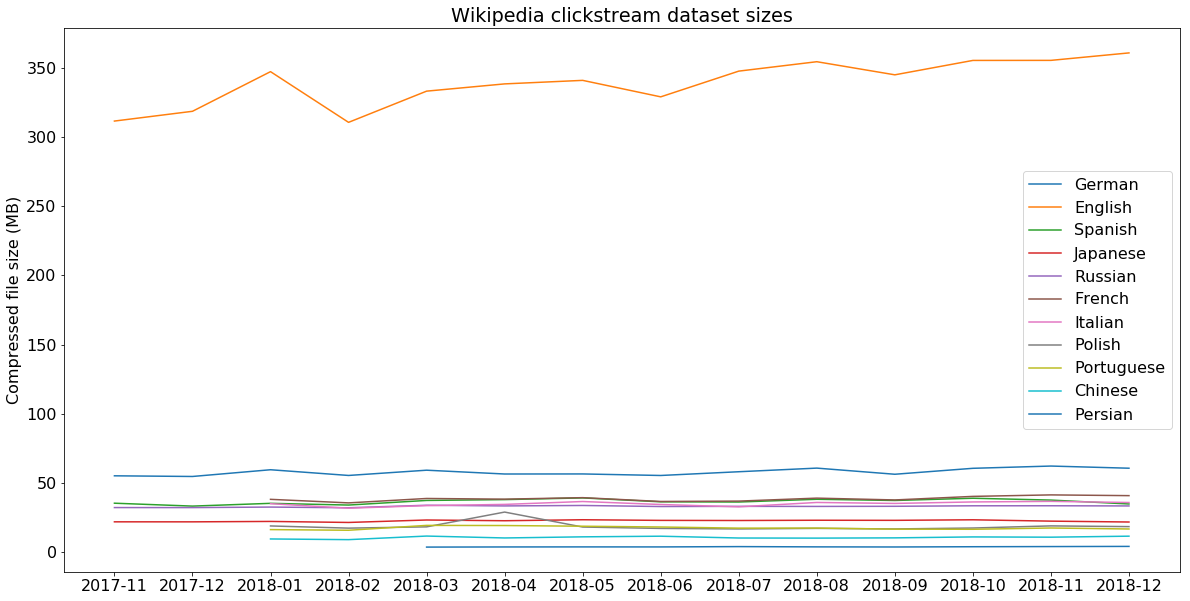

In [205]:
ax = plt.gca()
dataset_sizes_MB_zipped.plot(ax=ax)
plt.xticks(np.arange(len(dataset_sizes_MB_zipped.index)), dataset_sizes_MB_zipped.index)
ax.set_title("Wikipedia clickstream dataset sizes")
ax.set_ylabel("Compressed file size (MB)");

Zooming in on non-English Wikipedias

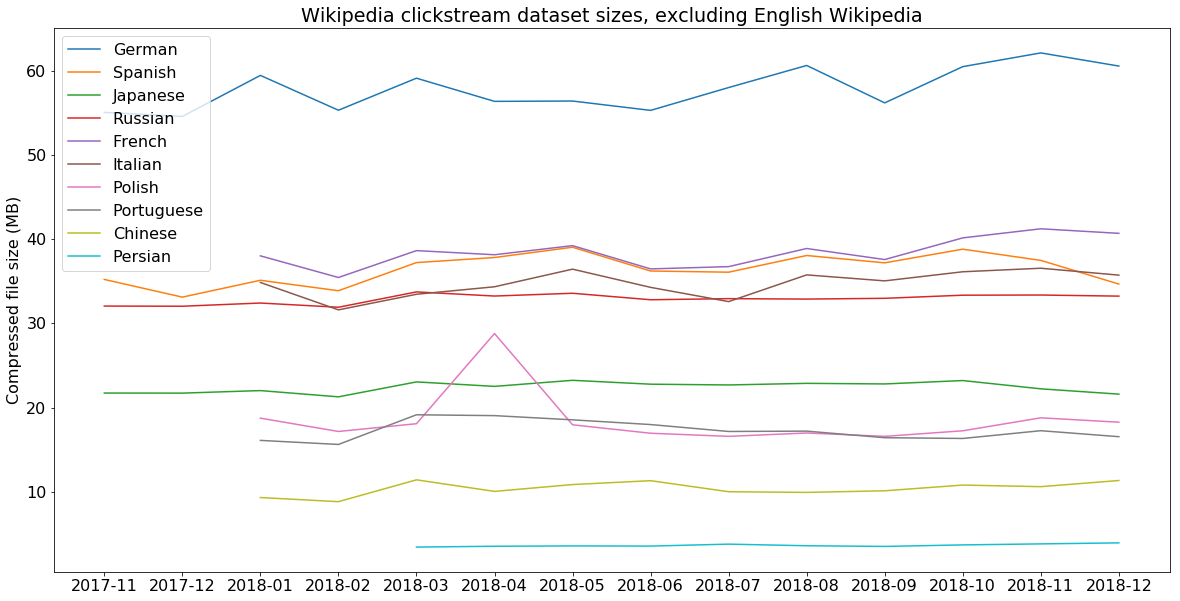

In [203]:
ax = plt.gca()
dataset_sizes_MB_zipped.drop('English', axis='columns').plot(ax=ax)
plt.xticks(np.arange(len(dataset_sizes_MB_zipped.index)), dataset_sizes_MB_zipped.index)
ax.set_title("Wikipedia clickstream dataset sizes, excluding English Wikipedia")
ax.set_ylabel("Compressed file size (MB)");

In [176]:
# Total count of clickstream data files available
sum(dataset_sizes_MB_zipped.count())

140

In [178]:
# Total size of the compressed files
print(sum(dataset_sizes_MB_zipped.sum())/1000, "GB")

8.31481 GB


#### Clickstream datasets summary
There are a total of 140 Wikipedia clickstream datasets currently available, spanning the last two months of 2017 and the entire year of 2018. The data is available for 5 languages in November and December of 2017, then the number of languages increases first to 10 in January 2018, and then to 11 in February 2018. 

The datasets are on the large side. The English Wikipedia clickstream data is much larger than the rest, with German dataset sizes a distant second. The English Wikipedia clickstream data sizes are also the most variable. Overall, Wikipedia clickstream data sizes seem stable over time, with the exception of a sharp jump in Polish Wikipedia clickstream in April 2018.

#### Additional Wikipedia data

Wikimedia and Wikipedia provide lots of statistics and analytics resources on Wikipedia structure and usage that are a great starting point for further analyses.  
Here are a few:  
- [List of Wikipedias with some basic stats](https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list)
- [Wikimedia stats dashboard](https://stats.wikimedia.org/v2/#/all-projects)
- [Top views analysis tool](https://tools.wmflabs.org/topviews/)


### 2. Sample raw data file
The format of the Wikipedia clickstream datasets is described [here](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format), and should be uniform across the langauage domains and months. 

#### Let's examine the raw English Wikipedia clickstream dataset for the month of December 2018. 

TODO: move somewhere else  
[EN Wikipedia Statistics page](https://en.wikipedia.org/w/index.php?title=Special:Statistics&action=raw)

[EN Wikipedia Topviews Analysis for December 2018](https://tools.wmflabs.org/topviews/?project=en.wikipedia.org&platform=all-access&date=2018-12&excludes=)

[Wikipedia stats by language, for top languages](https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list)

[Wikimedia stats dashboard for EN Wikipedia](https://stats.wikimedia.org/v2/#/en.wikipedia.org)

TODO: move somewhere else  
following this jupyter notebook as an example: https://github.com/valgog/wmf/blob/master/clickstream/ipython/Wikipedia%20Clickstream%20-%20Getting%20Started-Extended.ipynb 


In [221]:
# Read the EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12.tsv"
start_time = timer()
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])
end_time = timer()
print("read_csv runtime:", (end_time - start_time)/60, "min\n")

read_csv runtime: 0.5469894766833022 min



In [222]:
# Check that the file was read in correctly
df.head()

,prev,curr,type,n
0,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
1,other-search,ForeverAtLast,external,40
2,other-empty,ForeverAtLast,external,85
3,First_Families_of_Pakistan,Jehangir_Wadia,link,19
4,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29843928 entries, 0 to 29843927
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int64
dtypes: int64(1), object(3)
memory usage: 910.8+ MB


In [257]:
pd.options.display.float_format = '{:.0f}'.format # this is to avoid scientific notation

# Describe the distribution of the page-to-page traffic, for all referer types
df.describe(include="all")

,prev,curr,type,n
count,29843928,29843928,29843928,29843928
unique,1714208,5183180,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


Looking at the dataframe description above, the counts for the `prev` and `curr` columns look off. According to [Wikipedia's data format description for this dataset](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format), we should not have any missing values, so all column value counts should equal the number of entries in the dataset. Let's investigate the missing values in `prev` and `curr` columns.

In [226]:
df[df["prev"].isna()]

,prev,curr,type,n
24804,NaN,Denormal_number,link,26
785022,NaN,Hyphen-minus,other,10
1019421,NaN,Sodium_azide,link,35
3556686,NaN,Indeterminate_form,link,60
4748727,NaN,Imaginary_number,link,24
4754049,NaN,IEEE_754-2008_revision,link,18
5902556,NaN,IEEE_754,link,188
6525955,NaN,Undefined_behavior,link,18
7884601,NaN,Main_Page,other,23
10368848,NaN,Zero_to_the_power_of_zero,link,28


In [227]:
len(df[df["prev"].isna()])

22

In [228]:
df[df["curr"].isna()]

,prev,curr,type,n
5114052,JSON,NaN,link,104
5114053,other-external,NaN,external,447
5114054,Zero_to_the_power_of_zero,NaN,link,17
5114055,Signed_zero,NaN,link,34
5114056,Division_by_zero,NaN,link,72
5114057,IEEE_754-1985,NaN,link,50
5114058,Half-precision_floating-point_format,NaN,link,18
5114059,Magic_number_(programming),NaN,link,40
5114060,Double-precision_floating-point_format,NaN,link,69
5114061,other-internal,NaN,external,260


In [229]:
len(df[df["curr"].isna()])

22

In [230]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [231]:
# we want the output here to be string
type(df.loc[5114052]["curr"]) 

float

We seem to have some missing values in the data. Let's take a look in the input tsv file.

In [232]:
# check the datalines in the raw input file
!sed '5114050,5114055!d' ../data/clickstream-enwiki-2018-12.tsv

other-search	Auas_Mountains	external	19
other-empty	John_Bagley	external	12
other-search	John_Bagley	external	10
JSON	NaN	link	104
other-external	NaN	external	447
Zero_to_the_power_of_zero	NaN	link	17


From the raw tsv, it looks like NaN is not a missing value in the columns, but an actual Wikipedia article title, which indeed exists: [NaN wiki page](https://en.wikipedia.org/wiki/NaN).

Since Pandas does not treat the missing value NaN as a regular cateogrical value (it's excluded from counts, groupbys, etc.), we need to convert it to string. 

In [233]:
# Replace the false missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [234]:
df.describe(include="all")

,prev,curr,type,n
count,29843928,29843928,29843928,29843928
unique,1714208,5183180,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


In [235]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [236]:
type(df.loc[5114052]["curr"]) 

str

The dataset description table above now looks fairly consistent with the data format description: no missing values, lots of unique `prev` and `curr` values, 3 unique values for link type, and a numerical link traffic volume field `n`, with a minimum cutoff at 10.  

Next, let's take a look at the distribution of link traffic volume values, to make sure that the distribution makes sense and to catch any data anomalies.

#### Page-to-page link traffic distribution

In [239]:
df["n"].describe()

count    29843928
mean          230
std         90309
min            10
25%            15
50%            28
75%            71
max     492341152
Name: n, dtype: float64

From the univariate stats above, we can see that most page-to-page link traffic volumes over the course of December 2018 are quite low, with 50% of them being 28 or less. 

In [237]:
edge_traffic_frequencies = df["n"].value_counts()

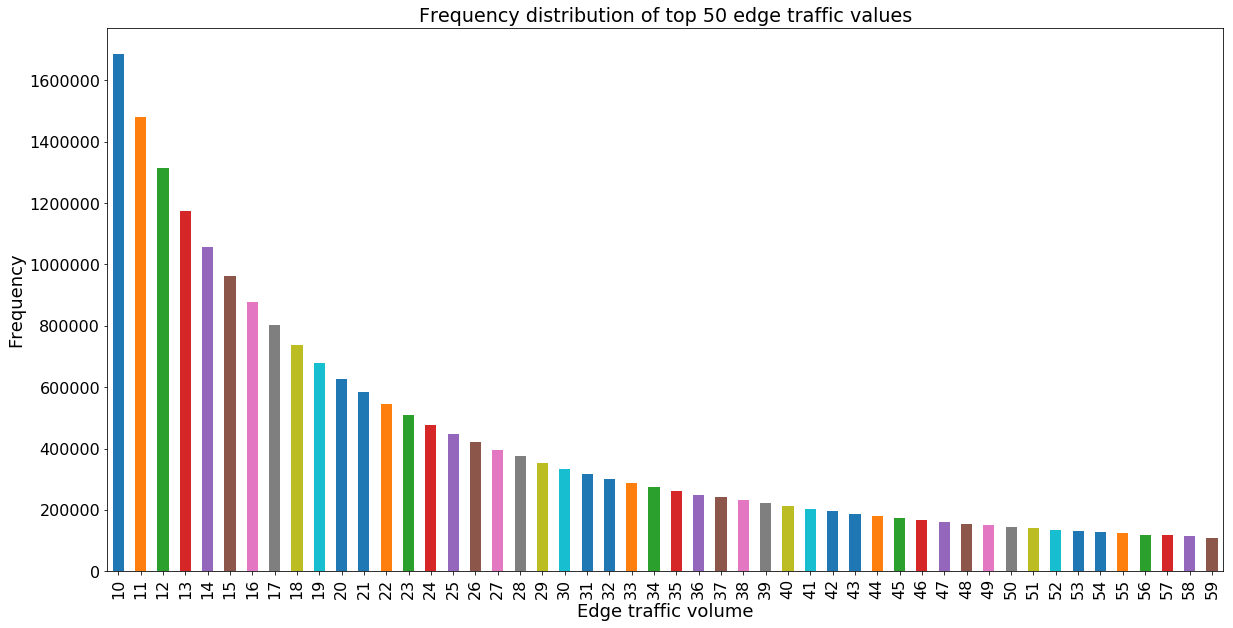

In [238]:
bar_chart = edge_traffic_frequencies.head(50).plot.bar(title="Frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Frequency', fontsize = 18);

In [240]:
edge_traffic_rel_frequencies = edge_traffic_frequencies/len(df)

In [241]:
edge_traffic_rel_frequencies.values[:10]

array([0.05652721, 0.04960503, 0.04399119, 0.03934445, 0.03546021,
       0.03223332, 0.02937371, 0.02684831, 0.02471927, 0.02278809])

In [242]:
# Relative freq of edges with traffic volume of 20 or less
sum(edge_traffic_rel_frequencies.values[:11])

0.3819373575757186

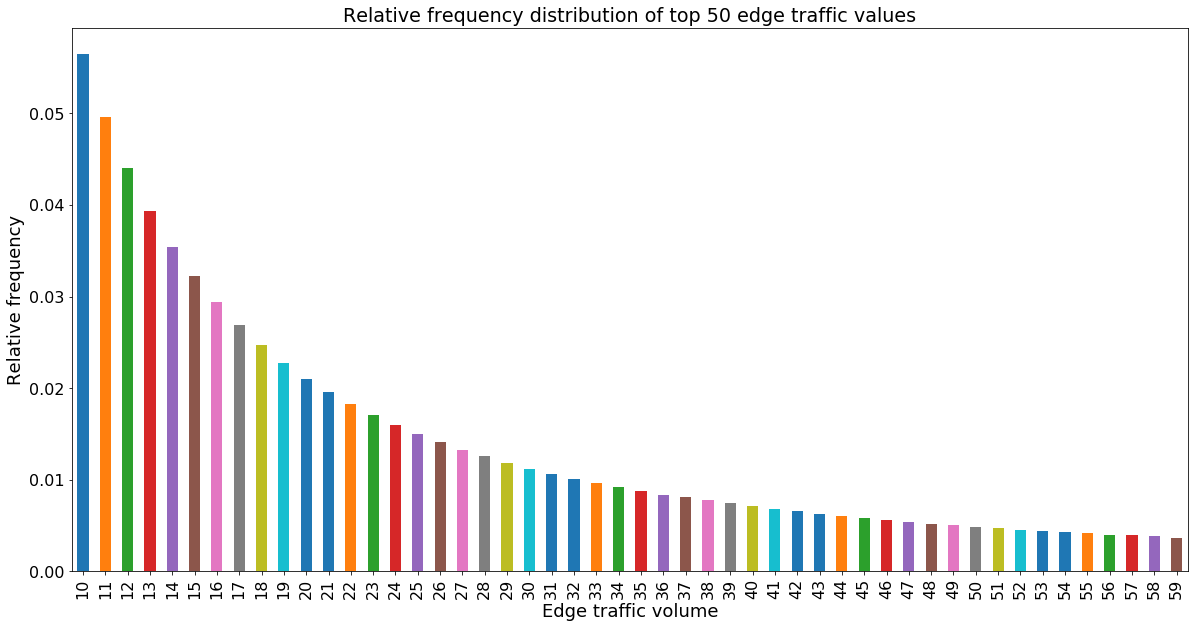

In [243]:
bar_chart = edge_traffic_rel_frequencies.head(50) \
    .plot.bar(title="Relative frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Relative frequency', fontsize = 18);

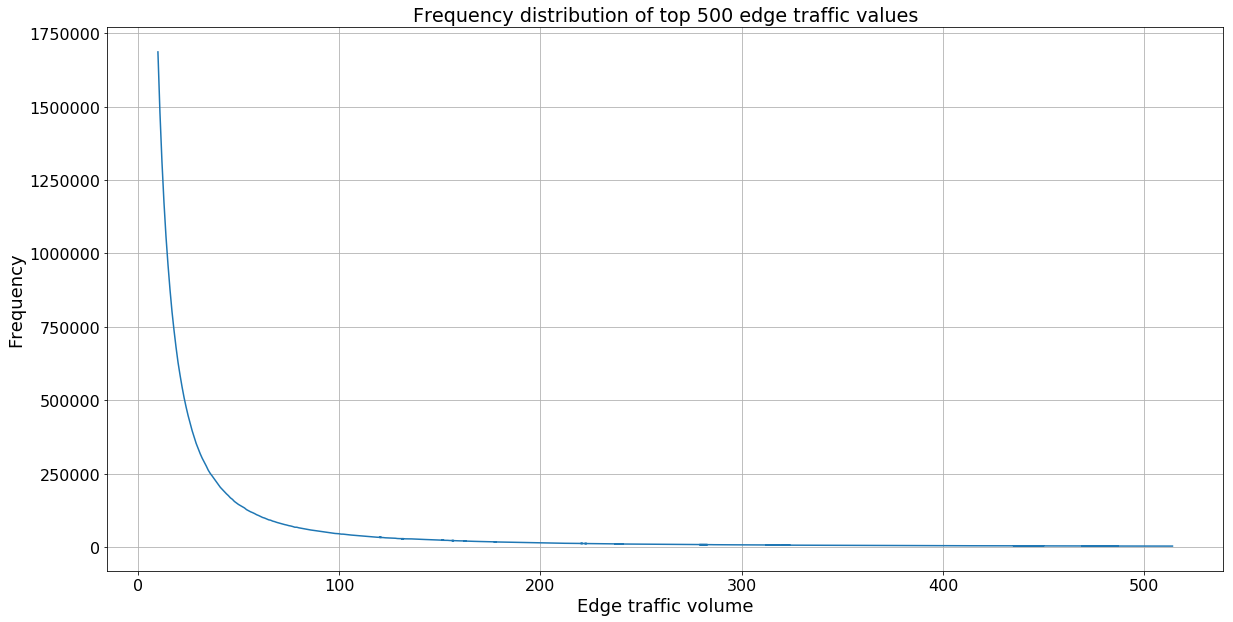

In [244]:
line_chart = edge_traffic_frequencies.head(500) \
    .plot.line(title="Frequency distribution of top 500 edge traffic values", grid=True)

line_chart.set_xlabel('Edge traffic volume', fontsize = 18)
line_chart.set_ylabel('Frequency', fontsize = 18);

The frequency distribution charts above show a long-tailed distribution, with highly frequent low values and low-frequency high values. This means that most page-to-page links were traversed a fairly small number of times in December 2018, while a few page-to-page links are traversed a very large number of times.  
This is consistent with what we would expect to see in network data, especially when it is a result of social network behavior. People tend to look up popular topics on Wikipedia, and so popular links are likely to be followed more and more as they become more popular.  

Processes like this can often be described with a power law distribution. A necessary (but not sufficient) condition for a power law distribution is that it looks like a line on a log-log scale.

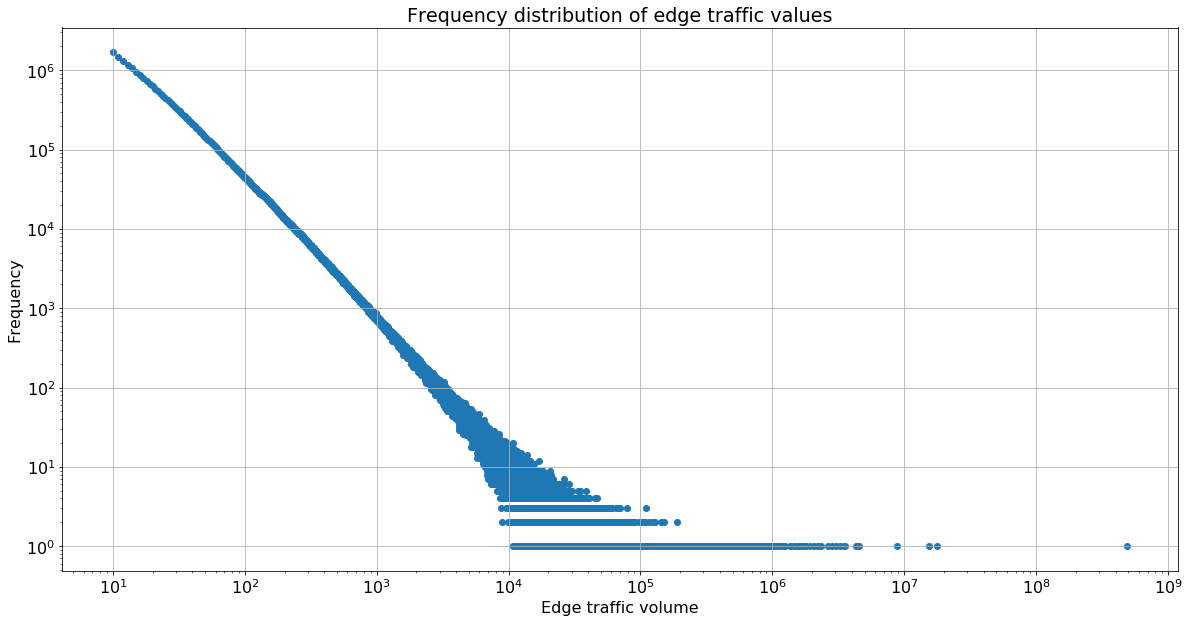

In [246]:
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of edge traffic values");

The log-log plot above shows something very close to a line for the lower values of link traffic volume, but the higher link traffic volume values fan out. The higher volume traffic values are messier, which would make it difficult to fit a line here. This can be addressed with logarithmic binning. We can do that and try to fit a powerlaw using the `powerlaw` package.

In [250]:
# numpy array of link traffic volume values
data = df["n"].values

In [251]:
start_time = timer()
results = powerlaw.Fit(data)
end_time = timer()
print("Runtime:", round((end_time - start_time)/60, 2), "min\n")

Calculating best minimal value for power law fit


Runtime: 30.67 min



In [252]:
print(results.power_law.alpha)
print(results.power_law.xmin)

2.7465478170902196
97984.0


In [253]:
R, p = results.distribution_compare('power_law', 'lognormal')

In [254]:
R

0.04186593354597434

In [255]:
p

0.544845625004867

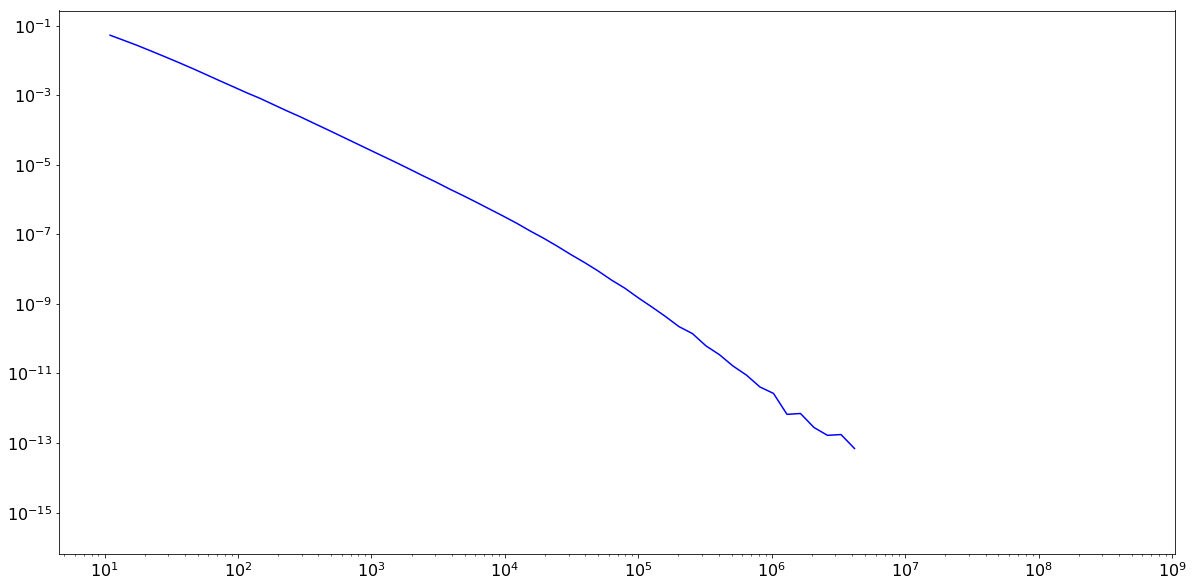

In [256]:
powerlaw.plot_pdf(data, color='b');

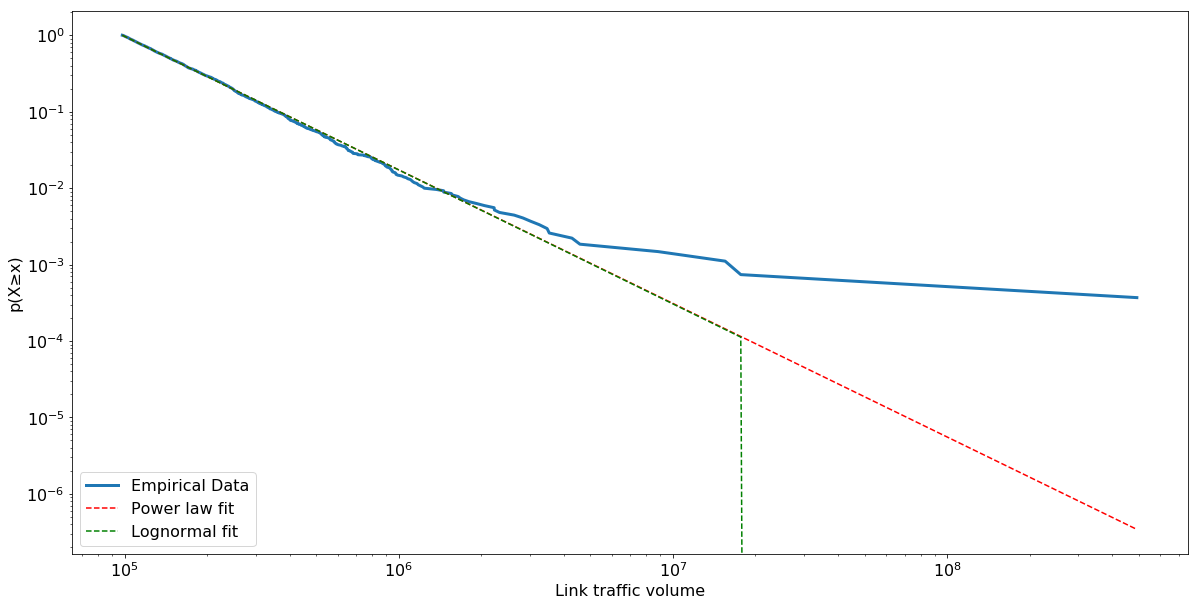

In [259]:

fig = results.plot_ccdf(linewidth=3, label='Empirical Data')
results.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
results.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Link traffic volume")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3);

It looks like power law fits the data well for lower values of link traffic volume, but doesn't do so well for the extremely high link traffic values. And it looks like power law isn't a significantly better fit than a lognormal distribution for this data.  

So let's take a closer look at the edges with the highest traffic.

In [260]:
df_sorted = df.sort_values("n", ascending=False)

In [261]:
df_sorted.head(20)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21248650,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23947949,other-search,Jason_Momoa,external,3538068
18399721,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


In [24]:
df.groupby('curr').sum().sort_values('n', ascending=False)[:10]

,n
curr,
Main_Page,508992230
Hyphen-minus,42300873
George_H._W._Bush,6891439
Jason_Momoa,5261261
2.0_(film),4775391
Bird_Box_(film),4710338
XHamster,4354947
Aquaman_(film),3887205
Lists_of_deaths_by_year,3357694


In [25]:

clickstream = nx.DiGraph()

In [44]:
start_time = timer()
rows_total_count = len(df)

for i, row in df.iterrows():
    clickstream.add_edge(row['prev'], row['curr'], traffic = row['n'], link_type = row['type'])
    if i % 1000000 == 0:
        print(f'{round(i/rows_total_count * 100)}% done')
        print("elapsed time:", (timer() - start_time)/60, "min\n")
        
end_time = timer()


0% done
elapsed time: 0.1447992557666718 min

3% done
elapsed time: 1.5585065293499913 min

7% done
elapsed time: 3.004428672949992 min

10% done
elapsed time: 4.6194380532333374 min

13% done
elapsed time: 6.5980846082833375 min

17% done
elapsed time: 8.514604662500005 min

20% done
elapsed time: 10.367447325183337 min

23% done
elapsed time: 12.289904162466671 min

27% done
elapsed time: 14.295300761433328 min

30% done
elapsed time: 17.268469321966663 min

34% done
elapsed time: 19.47021953116667 min

37% done
elapsed time: 22.019473073716668 min

40% done
elapsed time: 24.102339129033332 min

44% done
elapsed time: 26.260862174333337 min

47% done
elapsed time: 28.20153869233333 min

50% done
elapsed time: 30.125884280433336 min

54% done
elapsed time: 32.094530061233336 min

57% done
elapsed time: 34.37006730806667 min

60% done
elapsed time: 36.96948394975001 min

64% done
elapsed time: 38.918416953716665 min

67% done
elapsed time: 40.89315858731667 min

70% done
elapsed time: 

In [45]:

print("add_edge total runtime:", (end_time - start_time)/60, "min\n")

add_edge total runtime: 66.51817008306666 min



In [53]:
clickstream.number_of_nodes()

5185321

In [57]:
start_time = timer()
pr = nx.pagerank(clickstream, alpha=0.9, weight = 'traffic')
end_time = timer()
print ("Runtime:", (end_time - start_time)/60, "min\n")

Runtime: 71.09349475370011 min



In [58]:
pr

{'other-empty': 1.3547285920117938e-07,
 '2019_Horizon_League_Baseball_Tournament': 1.3547286076148575e-07,
 'other-search': 1.3547285920117938e-07,
 'ForeverAtLast': 1.354728697786122e-07,
 'First_Families_of_Pakistan': 2.0683241786700676e-07,
 'Jehangir_Wadia': 2.8309350055981834e-07,
 'The_Lawrence_School,_Sanawar': 6.735126231197098e-07,
 'Wadia_family': 6.817899468542883e-07,
 'Ness_Wadia': 5.434117809234895e-07,
 'GoAir': 3.221213549944152e-07,
 'other-internal': 1.3547285920117938e-07,
 'Lovji_Nusserwanjee_Wadia': 1.902740674602411e-07,
 'Sangh_Parivar': 5.209159384942201e-07,
 'other-other': 1.3547285920117938e-07,
 'Parsi': 3.0008396254043805e-06,
 'Bombay_Dyeing': 1.8050202413646182e-07,
 'Wadia_Group': 4.7184095308030776e-07,
 'Dina_Wadia': 5.148782965399126e-07,
 'The_Age_of_Stupid': 5.103632187608094e-07,
 'other-external': 1.3547285920117938e-07,
 'Nusli_Wadia': 5.639474231832628e-07,
 'Neville_Wadia': 2.545217123874753e-07,
 'Metallate': 1.3547286497409683e-07,
 'Bob_Ham

In [63]:
start_time = timer()
pr2 = nx.pagerank_scipy(clickstream, alpha=0.9, weight = 'traffic')
end_time = timer()
print ("Runtime:", (end_time - start_time)/60, "min\n")

Runtime: 43.7223660145999 min

